In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import backend as K
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adamax
from keras.callbacks import EarlyStopping
from keras.models import load_model
import tensorflow.keras.callbacks as callbacks
import keras_tuner
from keras_tuner.tuners import RandomSearch
from sklearn.metrics import confusion_matrix
import pickle



# EDA

In [2]:
df=pd.read_csv('archive/GroundTruth.csv', sep=',')
df['image']=df['image'].apply(lambda x: x+ '.jpg')
df

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
10010,ISIC_0034316.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10011,ISIC_0034317.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10012,ISIC_0034318.jpg,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10013,ISIC_0034319.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'diagnostic categories of skin cancer dataset')

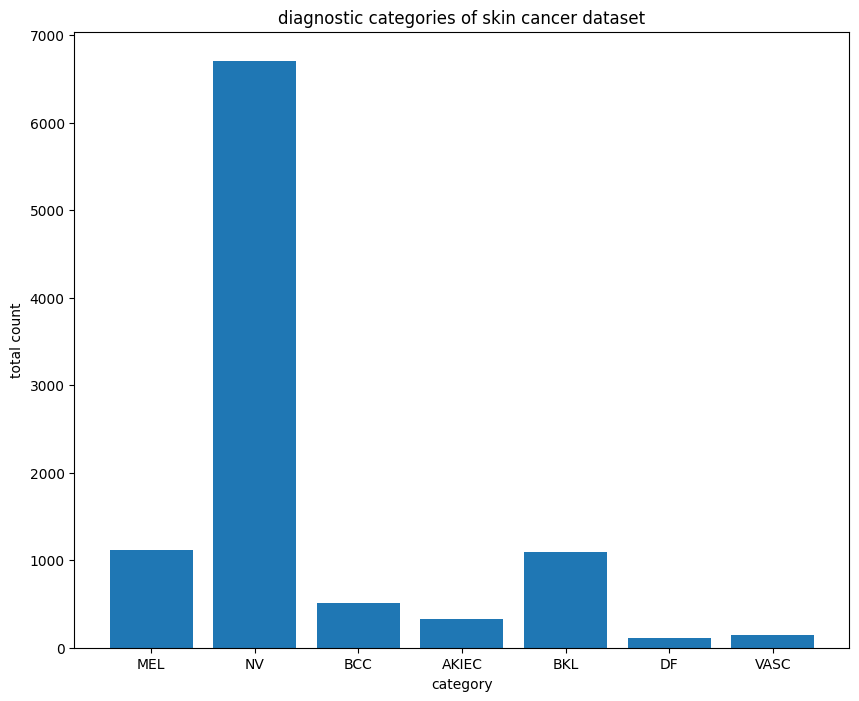

In [3]:
#create charts-> visualize total counts of all lesion categories:
category_counts = df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].sum()
plt.figure(figsize=(10, 8))
plt.bar(category_counts.index, category_counts.values) 
plt.xlabel('category')
plt.ylabel('total count')
plt.title('diagnostic categories of skin cancer dataset')          

In [4]:
df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].sum()

MEL      1113.0
NV       6705.0
BCC       514.0
AKIEC     327.0
BKL      1099.0
DF        115.0
VASC      142.0
dtype: float64

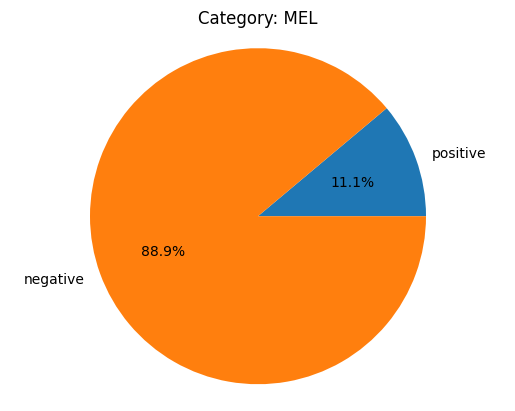

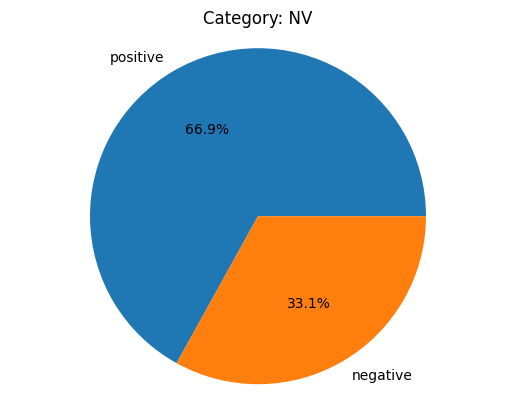

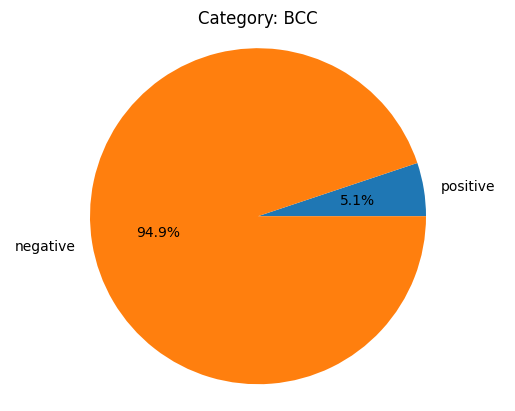

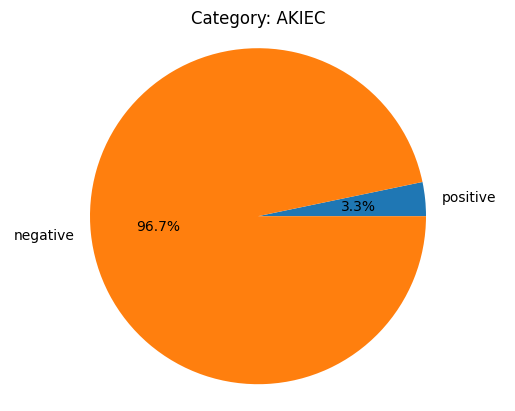

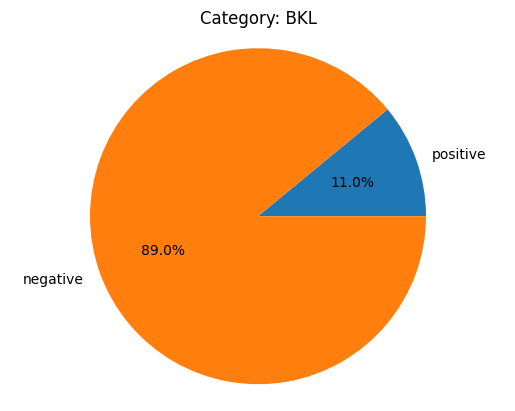

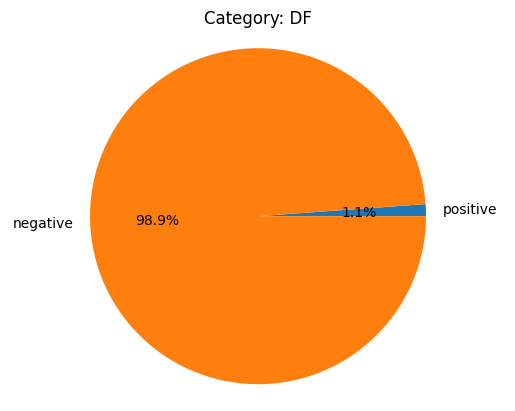

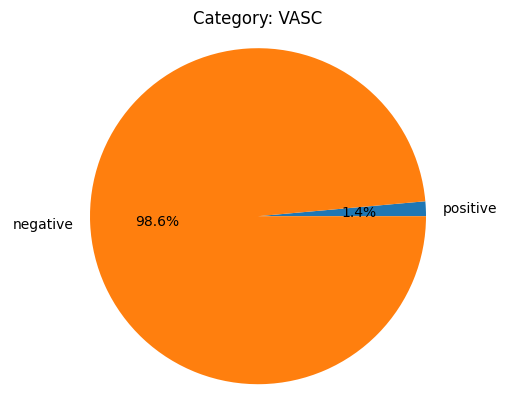

In [5]:
for category, count in category_counts.items():
    # Calculate the percentage of 1 and 0 within the category
    percentages = [count, len(df) - count]
    labels = ['positive', 'negative']

    # Create the pie chart
    plt.figure()
    plt.pie(percentages, labels=labels, autopct='%1.1f%%')
    plt.title(f'Category: {category}')

    # Equal aspect ratio ensures that pie is drawn as a circle
    plt.axis('equal')

# Display the pie charts
plt.show()

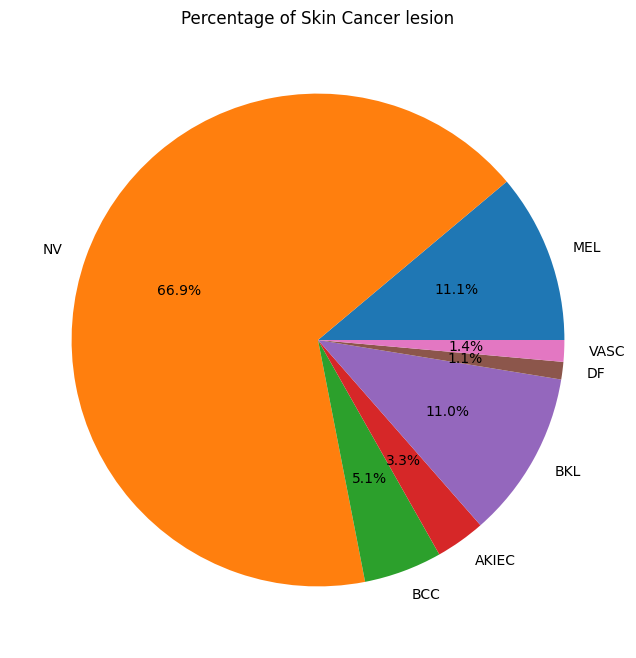

In [6]:
column_percentages = df.iloc[:, 1:].mean() * 100
plt.figure(figsize=(10, 8))
# Create a pie chart
plt.pie(column_percentages, labels=column_percentages.index, autopct='%.1f%%')
# Add a title
plt.title('Percentage of Skin Cancer lesion')
# Display the chart
plt.show()

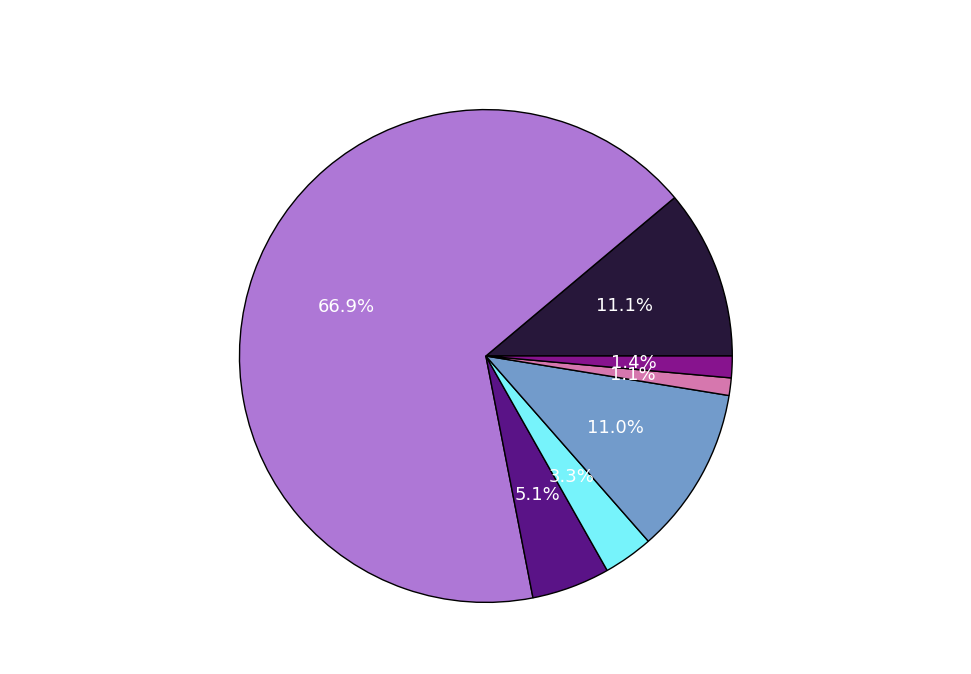

In [34]:
column_percentages = df.iloc[:, 1:].mean() * 100
# Define the colors in the desired order

# Define the colors in the desired order
colors = ['#27173a','#ae77d6', '#5a1387', '#76f3fb',  '#729bcb' , '#d677ae', '#87138e']

plt.figure(figsize=(10, 8))

# Create a pie chart with custom colors and bigger, white labels
plt.pie(column_percentages, labels=column_percentages.index, autopct='%.1f%%', colors=colors,
        textprops={'fontsize': 13, 'color': 'white'}, wedgeprops={'edgecolor': 'black'})

# Add a title
plt.title('Percentage of Diagnostic Skin Cancer Categories', fontsize=28, color='white')

# Save the plot as an image file with transparent background (e.g., PNG)
plt.savefig('skin_cancer_pie_chart.png', transparent=True)

# Display the chart
plt.show()


# Data Preprocessing

In [8]:
def random_under_sampling(df, categories, sample_size):
    """
    Function to random undersample datasets by given categories and sample size
    --------------
    Parameter: df: dataframe, categories: categories of samples, sample_size: size of sample per category.
    --------------
    Return: under_sampled_data
    """
    
    # Separate the data based on categories
    category_data = {category: df[df[category] == 1] for category in categories}

    # Randomly under-sample each category to sample_size samples
    under_sampled_data = pd.DataFrame()

    for category in categories:
        if len(category_data[category]) > sample_size:
            under_sampled_data = pd.concat([under_sampled_data, category_data[category].sample(sample_size, random_state=42)])
        else:
            under_sampled_data = pd.concat([under_sampled_data, category_data[category]])

    # Shuffle the final under-sampled data
    under_sampled_data = under_sampled_data.sample(frac=1).reset_index(drop=True)

    return under_sampled_data

In [9]:
#undersample the dataframe
categories=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
sample_size = 150
under_sampled_data = random_under_sampling(df, categories, sample_size)

In [10]:
def process_images(base_path_image, df, image_size=(224, 224)):
    """
    Function that loads images, reshape them to image_size (224, 224) and transform them into numpy arrays.
    -----------
    Variables: base_path_image: directory path of image file e.g.'Desktop/to/your/image/directory',
               df: dataframe that contains image file names (incl. datatype suffix), image_size: reshaping size.
    -----------
    Returns:   <images>, list of image arrays 
    """
    images = []
    files = os.listdir(base_path_image)
    
    for file in df['image']:
        if not file.endswith(('.jpg', '.jpeg', '.png', '.gif')):
            continue
        img = Image.open(os.path.join(base_path_image, file))
        name = file
        new_width, new_height = image_size
        resized_image = img.resize((new_width, new_height))
        img_array = np.array(resized_image)
        images.append({'image': name, 'array': img_array})
    
    return images

In [11]:
# load pictures and preprocessing
base_path_image = '/Users/nando_macbook/Desktop/final_project/archive/images/'
#classes = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
#base_path_mask='/Users/nando_macbook/Desktop/final_project/archive/masks/'

images= process_images(base_path_image, under_sampled_data)
images

[{'image': 'ISIC_0033855.jpg',
  'array': array([[[186, 171, 189],
          [185, 173, 190],
          [184, 169, 187],
          ...,
          [181, 161, 180],
          [181, 163, 182],
          [181, 164, 182]],
  
         [[184, 168, 182],
          [184, 171, 187],
          [188, 171, 191],
          ...,
          [181, 163, 181],
          [182, 164, 182],
          [181, 161, 182]],
  
         [[181, 167, 180],
          [183, 168, 185],
          [185, 172, 188],
          ...,
          [182, 163, 181],
          [184, 163, 182],
          [182, 163, 183]],
  
         ...,
  
         [[181, 169, 187],
          [183, 168, 187],
          [181, 168, 187],
          ...,
          [175, 153, 164],
          [174, 154, 162],
          [175, 154, 163]],
  
         [[182, 169, 186],
          [182, 170, 187],
          [183, 169, 188],
          ...,
          [177, 153, 164],
          [176, 155, 164],
          [177, 156, 164]],
  
         [[181, 167, 185],
          [

In [12]:
df_pic = pd.DataFrame(images)
df_pic

,image,array
0,ISIC_0033855.jpg,"[[[186, 171, 189], [185, 173, 190], [184, 169,..."
1,ISIC_0031335.jpg,"[[[173, 123, 126], [176, 122, 121], [173, 117,..."
2,ISIC_0028432.jpg,"[[[226, 138, 151], [225, 136, 149], [225, 136,..."
3,ISIC_0024375.jpg,"[[[209, 151, 157], [209, 149, 157], [213, 154,..."
4,ISIC_0030369.jpg,"[[[27, 15, 14], [28, 14, 13], [28, 12, 12], [2..."
...,...,...
1002,ISIC_0025986.jpg,"[[[248, 217, 215], [248, 217, 215], [248, 217,..."
1003,ISIC_0027442.jpg,"[[[221, 192, 195], [223, 195, 196], [224, 195,..."
1004,ISIC_0024923.jpg,"[[[148, 110, 113], [151, 113, 114], [154, 115,..."
1005,ISIC_0025144.jpg,"[[[172, 120, 98], [170, 114, 95], [171, 117, 1..."


In [13]:
merged_df = df_pic.merge(under_sampled_data[['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']], on='image', how='left')
merged_df

,image,array,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0033855.jpg,"[[[186, 171, 189], [185, 173, 190], [184, 169,...",0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,ISIC_0031335.jpg,"[[[173, 123, 126], [176, 122, 121], [173, 117,...",0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,ISIC_0028432.jpg,"[[[226, 138, 151], [225, 136, 149], [225, 136,...",0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024375.jpg,"[[[209, 151, 157], [209, 149, 157], [213, 154,...",0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,ISIC_0030369.jpg,"[[[27, 15, 14], [28, 14, 13], [28, 12, 12], [2...",0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1002,ISIC_0025986.jpg,"[[[248, 217, 215], [248, 217, 215], [248, 217,...",0.0,0.0,0.0,0.0,1.0,0.0,0.0
1003,ISIC_0027442.jpg,"[[[221, 192, 195], [223, 195, 196], [224, 195,...",1.0,0.0,0.0,0.0,0.0,0.0,0.0
1004,ISIC_0024923.jpg,"[[[148, 110, 113], [151, 113, 114], [154, 115,...",0.0,0.0,0.0,1.0,0.0,0.0,0.0
1005,ISIC_0025144.jpg,"[[[172, 120, 98], [170, 114, 95], [171, 117, 1...",0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [14]:
#checking for Nas
merged_df.isna().sum()

image    0
array    0
MEL      0
NV       0
BCC      0
AKIEC    0
BKL      0
DF       0
VASC     0
dtype: int64

In [15]:
#checking the shapes
merged_df.iloc[0]['array'].shape

(224, 224, 3)

In [16]:
merged_df.iloc[0]['array']

array([[[186, 171, 189],
        [185, 173, 190],
        [184, 169, 187],
        ...,
        [181, 161, 180],
        [181, 163, 182],
        [181, 164, 182]],

       [[184, 168, 182],
        [184, 171, 187],
        [188, 171, 191],
        ...,
        [181, 163, 181],
        [182, 164, 182],
        [181, 161, 182]],

       [[181, 167, 180],
        [183, 168, 185],
        [185, 172, 188],
        ...,
        [182, 163, 181],
        [184, 163, 182],
        [182, 163, 183]],

       ...,

       [[181, 169, 187],
        [183, 168, 187],
        [181, 168, 187],
        ...,
        [175, 153, 164],
        [174, 154, 162],
        [175, 154, 163]],

       [[182, 169, 186],
        [182, 170, 187],
        [183, 169, 188],
        ...,
        [177, 153, 164],
        [176, 155, 164],
        [177, 156, 164]],

       [[181, 167, 185],
        [180, 169, 187],
        [184, 172, 189],
        ...,
        [176, 153, 163],
        [178, 155, 165],
        [177, 156, 165]]

In [17]:
def shape_check(df, shape):
    """
    Checks if the shape of all arrays within a dataframe is equal to defined shape.
    ------------------
    Parameter: 
    df: dataframe, shape: tuple of dimensions e.g. (450, 600, 3)
    ------------------
    Returns:
    Prints the shape of each array or "Shape is not <shape>. Shape is <shape_>".

    """
    for i in range(len(df)):
        shape_= df[i].shape
        if shape_ != shape:
            print(f'Shape is not {shape}. Shape is {shape_}')
        else:
            print(shape_)



In [18]:
shape_check(merged_df['array'], (224, 224, 3))

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 

# Train-Test Split

In [19]:
#defining arrays as X and binary encoded lesions as y
X=np.stack(merged_df['array'].values) #stacking possible since arrays!
y=merged_df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].values
X.shape, y.shape

((1007, 224, 224, 3), (1007, 7))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((755, 224, 224, 3), (252, 224, 224, 3), (755, 7), (252, 7))

# class weights, counteract class imbalance

In [21]:
#reverse OnehotEncoded y_train with argmax to use <compute_class_weigth>
y_train_index= np.argmax(y_train, axis=1, out=None)
class_labels=np.array([0, 1, 2, 3, 4, 5, 6]) #['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
number_class_labels=len(class_labels)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train_index)
class_weights_dict = dict(zip(class_labels, class_weights))
class_weights_dict

{0: 0.8988095238095238,
 1: 0.95448798988622,
 2: 1.0272108843537415,
 3: 0.95448798988622,
 4: 0.9630102040816326,
 5: 1.2541528239202657,
 6: 1.017520215633423}

# Keras Model

## Keras model 2, weighted class

# pretrained-model DenseNet201

In [ ]:
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=42)(x)        
output=Dense(number_class_labels, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
#define early_stopping
#early_stop = EarlyStopping(monitor='val_loss', patience=2)
checkpoint_filepath='/Users/nando_macbook/Desktop/final_project/checkpoints/best_model.h5'
model_check = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [58]:
DN_e91=pickle.load(open("DenseNet_s150_e91.sav", "rb"))

In [59]:
#continue training
history = DN_e91.fit(X_train,
                y_train,
                epochs = 109,
                batch_size = 40, 
                validation_split=0.2, class_weight=class_weights_dict, callbacks=[model_check])
pickle.dump(DN_e91, open("DenseNet_s150_new3.sav", "wb"))

Epoch 1/109
16/16 [==============================] - ETA: 0s - loss: 0.2858 - accuracy: 0.9834 
Epoch 1: val_loss improved from inf to 1.55738, saving model to /Users/nando_macbook/Desktop/final_project/checkpoints/best_model.h5


/Users/nando_macbook/anaconda3/envs/final_project/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 328s 18s/step - loss: 0.2858 - accuracy: 0.9834 - val_loss: 1.5574 - val_accuracy: 0.6689
Epoch 2/109
16/16 [==============================] - ETA: 0s - loss: 0.2567 - accuracy: 0.9917 
Epoch 2: val_loss improved from 1.55738 to 0.92815, saving model to /Users/nando_macbook/Desktop/final_project/checkpoints/best_model.h5
16/16 [==============================] - 354s 22s/step - loss: 0.2567 - accuracy: 0.9917 - val_loss: 0.9281 - val_accuracy: 0.8079
Epoch 3/109
16/16 [==============================] - ETA: 0s - loss: 0.2465 - accuracy: 0.9917 
Epoch 3: val_loss improved from 0.92815 to 0.82876, saving model to /Users/nando_macbook/Desktop/final_project/checkpoints/best_model.h5
16/16 [==============================] - 328s 20s/step - loss: 0.2465 - accuracy: 0.9917 - val_loss: 0.8288 - val_accuracy: 0.8278
Epoch 4/109
16/16 [==============================] - ETA: 0s - loss: 0.2457 - accuracy: 0.9901 
Epoch 4: val_loss did not improve from 0.8287

Epoch 30/109
16/16 [==============================] - ETA: 0s - loss: 0.2085 - accuracy: 0.9983 
Epoch 30: val_loss did not improve from 0.70444
16/16 [==============================] - 277s 17s/step - loss: 0.2085 - accuracy: 0.9983 - val_loss: 0.7306 - val_accuracy: 0.8609
Epoch 31/109
16/16 [==============================] - ETA: 0s - loss: 0.2265 - accuracy: 0.9901 
Epoch 31: val_loss did not improve from 0.70444
16/16 [==============================] - 314s 19s/step - loss: 0.2265 - accuracy: 0.9901 - val_loss: 0.9218 - val_accuracy: 0.8013
Epoch 32/109
16/16 [==============================] - ETA: 0s - loss: 0.2275 - accuracy: 0.9917 
Epoch 32: val_loss did not improve from 0.70444
16/16 [==============================] - 281s 17s/step - loss: 0.2275 - accuracy: 0.9917 - val_loss: 1.0197 - val_accuracy: 0.7748
Epoch 33/109
16/16 [==============================] - ETA: 0s - loss: 0.2179 - accuracy: 0.9950 
Epoch 33: val_loss did not improve from 0.70444
16/16 [====================

KeyboardInterrupt: 

## increase batch_size to 150

In [91]:
K.clear_session()

best_model= load_model('checkpoints/best_model.h5')
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

 conv2_block4_0_bn (BatchNo  (None, 56, 56, 160)          640       ['conv2_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block4_0_relu (Activ  (None, 56, 56, 160)          0         ['conv2_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_block4_1_conv (Conv2  (None, 56, 56, 128)          20480     ['conv2_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv2_block4_1_bn (BatchNo  (None, 56, 56, 128)          512       ['conv2_block4_1_conv[0][0]'] 
 rmalizati

 rmalization)                                                                                     
                                                                                                  
 conv3_block1_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block1_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block1_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block1_concat (Conca  (None, 28, 28, 160)          0         ['pool2_pool[0][0]',          
 tenate)                                                             'conv3_block1_2_conv[0][0]'] 
          

 conv3_block5_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block5_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block5_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block5_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block5_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block5_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block5_concat (Conca  (None, 28, 28, 288)          0         ['conv3_block4_concat[0][0]', 
 tenate)  

                                                                                                  
 conv3_block9_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block9_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block9_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block9_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_blo

 pool3_pool (AveragePooling  (None, 14, 14, 256)          0         ['pool3_conv[0][0]']          
 2D)                                                                                              
                                                                                                  
 conv4_block1_0_bn (BatchNo  (None, 14, 14, 256)          1024      ['pool3_pool[0][0]']          
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_0_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_1_conv (Conv2  (None, 14, 14, 128)          32768     ['conv4_block1_0_relu[0][0]'] 
 D)       

                                                                                                  
 conv4_block4_concat (Conca  (None, 14, 14, 384)          0         ['conv4_block3_concat[0][0]', 
 tenate)                                                             'conv4_block4_2_conv[0][0]'] 
                                                                                                  
 conv4_block5_0_bn (BatchNo  (None, 14, 14, 384)          1536      ['conv4_block4_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block5_0_relu (Activ  (None, 14, 14, 384)          0         ['conv4_block5_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block8_concat (Conca  (None, 14, 14, 512)          0         ['conv4_block7_concat[0][0]', 
 tenate)                                                             'conv4_block8_2_conv[0][0]'] 
                                                                                                  
 conv4_block9_0_bn (BatchNo  (None, 14, 14, 512)          2048      ['conv4_block8_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_0_relu (Activ  (None, 14, 14, 512)          0         ['conv4_block9_0_bn[0][0]']   
 ation)                                                                                           
          

 conv4_block12_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block12_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block12_concat (Conc  (None, 14, 14, 640)          0         ['conv4_block11_concat[0][0]',
 atenate)                                                            'conv4_block12_2_conv[0][0]']
                                                                                                  
 conv4_block13_0_bn (BatchN  (None, 14, 14, 640)          2560      ['conv4_block12_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block13_0_relu (Acti  (None, 14, 14, 640)          0         ['conv4_block13_0_bn[0][0]']  
 vation)  

                                                                                                  
 conv4_block16_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block16_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_concat (Conc  (None, 14, 14, 768)          0         ['conv4_block15_concat[0][0]',
 atenate)                                                            'conv4_block16_2_conv[0][0]']
                                                                                                  
 conv4_block17_0_bn (BatchN  (None, 14, 14, 768)          3072      ['conv4_block16_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block20_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block20_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block20_concat (Conc  (None, 14, 14, 896)          0         ['conv4_block19_concat[0][0]',
 atenate)                                                            'conv4_block20_2_conv[0][0]']
                                                                                                  
 conv4_block21_0_bn (BatchN  (None, 14, 14, 896)          3584      ['conv4_block20_concat[0][0]']
 ormalization)                                                                                    
          

 conv4_block24_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block24_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block24_concat (Conc  (None, 14, 14, 1024)         0         ['conv4_block23_concat[0][0]',
 atenate)                                                            'conv4_block24_2_conv[0][0]']
                                                                                                  
 conv4_block25_0_bn (BatchN  (None, 14, 14, 1024)         4096      ['conv4_block24_concat[0][0]']
 ormalizat

                                                                                                  
 conv4_block28_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block28_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block28_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block28_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block28_concat (Conc  (None, 14, 14, 1152)         0         ['conv4_block27_concat[0][0]',
 atenate)                                                            'conv4_block28_2_conv[0][0]']
                                                                                                  
 conv4_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block32_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block32_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block32_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block32_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block32_concat (Conc  (None, 14, 14, 1280)         0         ['conv4_block31_concat[0][0]',
 atenate)                                                            'conv4_block32_2_conv[0][0]']
          

 conv4_block36_1_bn (BatchN  (None, 14, 14, 128)          512       ['conv4_block36_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block36_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block36_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block36_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block36_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block36_concat (Conc  (None, 14, 14, 1408)         0         ['conv4_block35_concat[0][0]',
 atenate) 

                                                                                                  
 conv4_block40_1_bn (BatchN  (None, 14, 14, 128)          512       ['conv4_block40_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block40_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block40_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block40_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block40_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block44_1_bn (BatchN  (None, 14, 14, 128)          512       ['conv4_block44_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block44_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block44_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block44_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block44_1_relu[0][0]']
 2D)                                                                                              
          

 conv4_block48_1_conv (Conv  (None, 14, 14, 128)          225280    ['conv4_block48_0_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block48_1_bn (BatchN  (None, 14, 14, 128)          512       ['conv4_block48_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block48_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block48_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block48_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block48_1_relu[0][0]']
 2D)      

 D)                                                                                               
                                                                                                  
 conv5_block3_concat (Conca  (None, 7, 7, 992)            0         ['conv5_block2_concat[0][0]', 
 tenate)                                                             'conv5_block3_2_conv[0][0]'] 
                                                                                                  
 conv5_block4_0_bn (BatchNo  (None, 7, 7, 992)            3968      ['conv5_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block4_0_relu (Activ  (None, 7, 7, 992)            0         ['conv5_block4_0_bn[0][0]']   
 ation)                                                                                           
          

 conv5_block7_2_conv (Conv2  (None, 7, 7, 32)             36864     ['conv5_block7_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block7_concat (Conca  (None, 7, 7, 1120)           0         ['conv5_block6_concat[0][0]', 
 tenate)                                                             'conv5_block7_2_conv[0][0]'] 
                                                                                                  
 conv5_block8_0_bn (BatchNo  (None, 7, 7, 1120)           4480      ['conv5_block7_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block8_0_relu (Activ  (None, 7, 7, 1120)           0         ['conv5_block8_0_bn[0][0]']   
 ation)   

                                                                                                  
 conv5_block11_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block11_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block11_concat (Conc  (None, 7, 7, 1248)           0         ['conv5_block10_concat[0][0]',
 atenate)                                                            'conv5_block11_2_conv[0][0]']
                                                                                                  
 conv5_block12_0_bn (BatchN  (None, 7, 7, 1248)           4992      ['conv5_block11_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_blo

 vation)                                                                                          
                                                                                                  
 conv5_block15_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block15_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block15_concat (Conc  (None, 7, 7, 1376)           0         ['conv5_block14_concat[0][0]',
 atenate)                                                            'conv5_block15_2_conv[0][0]']
                                                                                                  
 conv5_block16_0_bn (BatchN  (None, 7, 7, 1376)           5504      ['conv5_block15_concat[0][0]']
 ormalization)                                                                                    
          

 conv5_block19_1_relu (Acti  (None, 7, 7, 128)            0         ['conv5_block19_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block19_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block19_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block19_concat (Conc  (None, 7, 7, 1504)           0         ['conv5_block18_concat[0][0]',
 atenate)                                                            'conv5_block19_2_conv[0][0]']
                                                                                                  
 conv5_block20_0_bn (BatchN  (None, 7, 7, 1504)           6016      ['conv5_block19_concat[0][0]']
 ormalizat

                                                                                                  
 conv5_block23_1_relu (Acti  (None, 7, 7, 128)            0         ['conv5_block23_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block23_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block23_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block23_concat (Conc  (None, 7, 7, 1632)           0         ['conv5_block22_concat[0][0]',
 atenate)                                                            'conv5_block23_2_conv[0][0]']
                                                                                                  
 conv5_blo

 ormalization)                                                                                    
                                                                                                  
 conv5_block27_1_relu (Acti  (None, 7, 7, 128)            0         ['conv5_block27_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block27_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block27_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block27_concat (Conc  (None, 7, 7, 1760)           0         ['conv5_block26_concat[0][0]',
 atenate)                                                            'conv5_block27_2_conv[0][0]']
          

 conv5_block31_1_bn (BatchN  (None, 7, 7, 128)            512       ['conv5_block31_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block31_1_relu (Acti  (None, 7, 7, 128)            0         ['conv5_block31_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block31_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block31_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block31_concat (Conc  (None, 7, 7, 1888)           0         ['conv5_block30_concat[0][0]',
 atenate) 

In [95]:
history = best_model.fit(X_train,
                y_train,
                epochs = 5,
                batch_size = 150, 
                validation_split=0.2, class_weight=class_weights_dict)

Epoch 1/5
5/5 [==============================] - 444s 79s/step - loss: 2.0250 - accuracy: 0.2566 - val_loss: 5.7931 - val_accuracy: 0.1656
Epoch 2/5
5/5 [==============================] - 407s 77s/step - loss: 1.7454 - accuracy: 0.3709 - val_loss: 6.0607 - val_accuracy: 0.1656
Epoch 3/5
5/5 [==============================] - 417s 80s/step - loss: 1.7179 - accuracy: 0.4040 - val_loss: 6.0488 - val_accuracy: 0.1656
Epoch 4/5
5/5 [==============================] - 414s 80s/step - loss: 1.5796 - accuracy: 0.4719 - val_loss: 6.0498 - val_accuracy: 0.1656
Epoch 5/5


KeyboardInterrupt: 

In [96]:
# batch_size of 150 leads into stagnation of val_accurary by 0.1656

## validation_split=0.4

In [97]:
K.clear_session()

best_model= load_model('checkpoints/best_model.h5')
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

 conv2_block4_0_bn (BatchNo  (None, 56, 56, 160)          640       ['conv2_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block4_0_relu (Activ  (None, 56, 56, 160)          0         ['conv2_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_block4_1_conv (Conv2  (None, 56, 56, 128)          20480     ['conv2_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv2_block4_1_bn (BatchNo  (None, 56, 56, 128)          512       ['conv2_block4_1_conv[0][0]'] 
 rmalizati

 rmalization)                                                                                     
                                                                                                  
 conv3_block1_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block1_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block1_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block1_concat (Conca  (None, 28, 28, 160)          0         ['pool2_pool[0][0]',          
 tenate)                                                             'conv3_block1_2_conv[0][0]'] 
          

 conv3_block5_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block5_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block5_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block5_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block5_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block5_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block5_concat (Conca  (None, 28, 28, 288)          0         ['conv3_block4_concat[0][0]', 
 tenate)  

                                                                                                  
 conv3_block9_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block9_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block9_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block9_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_blo

 pool3_pool (AveragePooling  (None, 14, 14, 256)          0         ['pool3_conv[0][0]']          
 2D)                                                                                              
                                                                                                  
 conv4_block1_0_bn (BatchNo  (None, 14, 14, 256)          1024      ['pool3_pool[0][0]']          
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_0_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_1_conv (Conv2  (None, 14, 14, 128)          32768     ['conv4_block1_0_relu[0][0]'] 
 D)       

                                                                                                  
 conv4_block4_concat (Conca  (None, 14, 14, 384)          0         ['conv4_block3_concat[0][0]', 
 tenate)                                                             'conv4_block4_2_conv[0][0]'] 
                                                                                                  
 conv4_block5_0_bn (BatchNo  (None, 14, 14, 384)          1536      ['conv4_block4_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block5_0_relu (Activ  (None, 14, 14, 384)          0         ['conv4_block5_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block8_concat (Conca  (None, 14, 14, 512)          0         ['conv4_block7_concat[0][0]', 
 tenate)                                                             'conv4_block8_2_conv[0][0]'] 
                                                                                                  
 conv4_block9_0_bn (BatchNo  (None, 14, 14, 512)          2048      ['conv4_block8_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_0_relu (Activ  (None, 14, 14, 512)          0         ['conv4_block9_0_bn[0][0]']   
 ation)                                                                                           
          

 conv4_block12_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block12_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block12_concat (Conc  (None, 14, 14, 640)          0         ['conv4_block11_concat[0][0]',
 atenate)                                                            'conv4_block12_2_conv[0][0]']
                                                                                                  
 conv4_block13_0_bn (BatchN  (None, 14, 14, 640)          2560      ['conv4_block12_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block13_0_relu (Acti  (None, 14, 14, 640)          0         ['conv4_block13_0_bn[0][0]']  
 vation)  

                                                                                                  
 conv4_block16_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block16_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_concat (Conc  (None, 14, 14, 768)          0         ['conv4_block15_concat[0][0]',
 atenate)                                                            'conv4_block16_2_conv[0][0]']
                                                                                                  
 conv4_block17_0_bn (BatchN  (None, 14, 14, 768)          3072      ['conv4_block16_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block20_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block20_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block20_concat (Conc  (None, 14, 14, 896)          0         ['conv4_block19_concat[0][0]',
 atenate)                                                            'conv4_block20_2_conv[0][0]']
                                                                                                  
 conv4_block21_0_bn (BatchN  (None, 14, 14, 896)          3584      ['conv4_block20_concat[0][0]']
 ormalization)                                                                                    
          

 conv4_block24_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block24_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block24_concat (Conc  (None, 14, 14, 1024)         0         ['conv4_block23_concat[0][0]',
 atenate)                                                            'conv4_block24_2_conv[0][0]']
                                                                                                  
 conv4_block25_0_bn (BatchN  (None, 14, 14, 1024)         4096      ['conv4_block24_concat[0][0]']
 ormalizat

                                                                                                  
 conv4_block28_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block28_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block28_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block28_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block28_concat (Conc  (None, 14, 14, 1152)         0         ['conv4_block27_concat[0][0]',
 atenate)                                                            'conv4_block28_2_conv[0][0]']
                                                                                                  
 conv4_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block32_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block32_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block32_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block32_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block32_concat (Conc  (None, 14, 14, 1280)         0         ['conv4_block31_concat[0][0]',
 atenate)                                                            'conv4_block32_2_conv[0][0]']
          

 conv4_block36_1_bn (BatchN  (None, 14, 14, 128)          512       ['conv4_block36_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block36_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block36_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block36_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block36_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block36_concat (Conc  (None, 14, 14, 1408)         0         ['conv4_block35_concat[0][0]',
 atenate) 

                                                                                                  
 conv4_block40_1_bn (BatchN  (None, 14, 14, 128)          512       ['conv4_block40_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block40_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block40_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block40_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block40_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block44_1_bn (BatchN  (None, 14, 14, 128)          512       ['conv4_block44_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block44_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block44_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block44_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block44_1_relu[0][0]']
 2D)                                                                                              
          

 conv4_block48_1_conv (Conv  (None, 14, 14, 128)          225280    ['conv4_block48_0_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block48_1_bn (BatchN  (None, 14, 14, 128)          512       ['conv4_block48_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block48_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block48_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block48_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block48_1_relu[0][0]']
 2D)      

 D)                                                                                               
                                                                                                  
 conv5_block3_concat (Conca  (None, 7, 7, 992)            0         ['conv5_block2_concat[0][0]', 
 tenate)                                                             'conv5_block3_2_conv[0][0]'] 
                                                                                                  
 conv5_block4_0_bn (BatchNo  (None, 7, 7, 992)            3968      ['conv5_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block4_0_relu (Activ  (None, 7, 7, 992)            0         ['conv5_block4_0_bn[0][0]']   
 ation)                                                                                           
          

 conv5_block7_2_conv (Conv2  (None, 7, 7, 32)             36864     ['conv5_block7_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block7_concat (Conca  (None, 7, 7, 1120)           0         ['conv5_block6_concat[0][0]', 
 tenate)                                                             'conv5_block7_2_conv[0][0]'] 
                                                                                                  
 conv5_block8_0_bn (BatchNo  (None, 7, 7, 1120)           4480      ['conv5_block7_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block8_0_relu (Activ  (None, 7, 7, 1120)           0         ['conv5_block8_0_bn[0][0]']   
 ation)   

                                                                                                  
 conv5_block11_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block11_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block11_concat (Conc  (None, 7, 7, 1248)           0         ['conv5_block10_concat[0][0]',
 atenate)                                                            'conv5_block11_2_conv[0][0]']
                                                                                                  
 conv5_block12_0_bn (BatchN  (None, 7, 7, 1248)           4992      ['conv5_block11_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_blo

 vation)                                                                                          
                                                                                                  
 conv5_block15_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block15_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block15_concat (Conc  (None, 7, 7, 1376)           0         ['conv5_block14_concat[0][0]',
 atenate)                                                            'conv5_block15_2_conv[0][0]']
                                                                                                  
 conv5_block16_0_bn (BatchN  (None, 7, 7, 1376)           5504      ['conv5_block15_concat[0][0]']
 ormalization)                                                                                    
          

 conv5_block19_1_relu (Acti  (None, 7, 7, 128)            0         ['conv5_block19_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block19_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block19_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block19_concat (Conc  (None, 7, 7, 1504)           0         ['conv5_block18_concat[0][0]',
 atenate)                                                            'conv5_block19_2_conv[0][0]']
                                                                                                  
 conv5_block20_0_bn (BatchN  (None, 7, 7, 1504)           6016      ['conv5_block19_concat[0][0]']
 ormalizat

                                                                                                  
 conv5_block23_1_relu (Acti  (None, 7, 7, 128)            0         ['conv5_block23_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block23_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block23_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block23_concat (Conc  (None, 7, 7, 1632)           0         ['conv5_block22_concat[0][0]',
 atenate)                                                            'conv5_block23_2_conv[0][0]']
                                                                                                  
 conv5_blo

 ormalization)                                                                                    
                                                                                                  
 conv5_block27_1_relu (Acti  (None, 7, 7, 128)            0         ['conv5_block27_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block27_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block27_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block27_concat (Conc  (None, 7, 7, 1760)           0         ['conv5_block26_concat[0][0]',
 atenate)                                                            'conv5_block27_2_conv[0][0]']
          

 conv5_block31_1_bn (BatchN  (None, 7, 7, 128)            512       ['conv5_block31_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block31_1_relu (Acti  (None, 7, 7, 128)            0         ['conv5_block31_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block31_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block31_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block31_concat (Conc  (None, 7, 7, 1888)           0         ['conv5_block30_concat[0][0]',
 atenate) 

In [105]:
checkpoint_filepath='/Users/nando_macbook/Desktop/final_project/checkpoints/best_model_valsplit_04.h5'
model_check = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [107]:
history = best_model.fit(X_train,
                y_train,
                epochs = 50,
                batch_size = 40, 
                validation_split=0.4, class_weight=class_weights_dict, callbacks=[model_check])

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 0.2261 - accuracy: 0.9934 
Epoch 1: val_loss improved from inf to 0.44763, saving model to /Users/nando_macbook/Desktop/final_project/checkpoints/best_model_valsplit_04.h5


/Users/nando_macbook/anaconda3/envs/final_project/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 253s 21s/step - loss: 0.2261 - accuracy: 0.9934 - val_loss: 0.4476 - val_accuracy: 0.9272
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 0.2182 - accuracy: 0.9934 
Epoch 2: val_loss improved from 0.44763 to 0.43058, saving model to /Users/nando_macbook/Desktop/final_project/checkpoints/best_model_valsplit_04.h5
12/12 [==============================] - 238s 19s/step - loss: 0.2182 - accuracy: 0.9934 - val_loss: 0.4306 - val_accuracy: 0.9238
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 0.2141 - accuracy: 0.9956 
Epoch 3: val_loss did not improve from 0.43058
12/12 [==============================] - 240s 20s/step - loss: 0.2141 - accuracy: 0.9956 - val_loss: 0.4308 - val_accuracy: 0.9238
Epoch 4/50
12/12 [==============================] - ETA: 0s - loss: 0.2123 - accuracy: 0.9934 
Epoch 4: val_loss improved from 0.43058 to 0.42695, saving model to /Users/nando_macbook/Desktop/final_project/checkpoints/bes

Epoch 29/50
12/12 [==============================] - ETA: 0s - loss: 0.2231 - accuracy: 0.9868 
Epoch 29: val_loss did not improve from 0.35419
12/12 [==============================] - 222s 19s/step - loss: 0.2231 - accuracy: 0.9868 - val_loss: 0.8717 - val_accuracy: 0.8113
Epoch 30/50
12/12 [==============================] - ETA: 0s - loss: 0.2328 - accuracy: 0.9868 
Epoch 30: val_loss did not improve from 0.35419
12/12 [==============================] - 227s 19s/step - loss: 0.2328 - accuracy: 0.9868 - val_loss: 0.9138 - val_accuracy: 0.7980
Epoch 31/50
12/12 [==============================] - ETA: 0s - loss: 0.2526 - accuracy: 0.9801 
Epoch 31: val_loss did not improve from 0.35419
12/12 [==============================] - 237s 20s/step - loss: 0.2526 - accuracy: 0.9801 - val_loss: 0.9849 - val_accuracy: 0.7914
Epoch 32/50
12/12 [==============================] - ETA: 0s - loss: 0.2084 - accuracy: 0.9956 
Epoch 32: val_loss did not improve from 0.35419
12/12 [========================

## smaller Adams learning rate 0.0001

In [ ]:
#best_model_Adam_lr.h5 doens't improve after 50 epochs using lr=0.0001

In [117]:
K.clear_session()

best_model= load_model('checkpoints/best_model_Adam_lr.h5')

In [118]:
checkpoint_filepath='/Users/nando_macbook/Desktop/final_project/checkpoints/best_model_Adam_lr_2.h5'
model_check = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [119]:
best_model.compile(Adamax(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [120]:
history = best_model.fit(X_train,
                y_train,
                epochs = 50,
                batch_size = 40, 
                validation_split=0.5, class_weight=
                class_weights_dict, callbacks=[model_check])

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 0.1928 - accuracy: 0.9973 
Epoch 1: val_loss improved from inf to 0.32193, saving model to /Users/nando_macbook/Desktop/final_project/checkpoints/best_model_Adam_lr_2.h5
10/10 [==============================] - 248s 21s/step - loss: 0.1928 - accuracy: 0.9973 - val_loss: 0.3219 - val_accuracy: 0.9550
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 0.1917 - accuracy: 0.9973 
Epoch 2: val_loss did not improve from 0.32193
10/10 [==============================] - 202s 20s/step - loss: 0.1917 - accuracy: 0.9973 - val_loss: 0.3293 - val_accuracy: 0.9603
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.1890 - accuracy: 0.9973 
Epoch 3: val_loss did not improve from 0.32193
10/10 [==============================] - 204s 21s/step - loss: 0.1890 - accuracy: 0.9973 - val_loss: 0.3464 - val_accuracy: 0.9550
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 0.1887 - accuracy

KeyboardInterrupt: 

## reducing batch_size <40

In [123]:
K.clear_session()
best_model= load_model('checkpoints/best_model_Adam_lr.h5')

checkpoint_filepath='/Users/nando_macbook/Desktop/final_project/checkpoints/best_model_batch_size_20.h5'
model_check = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True, verbose=1)

best_model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = best_model.fit(X_train,
                y_train,
                epochs = 10,
                batch_size = 20, 
                validation_split=0.4, class_weight=
                class_weights_dict, callbacks=[model_check])

Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 0.8636 - accuracy: 0.7859
Epoch 1: val_loss improved from inf to 3.46827, saving model to /Users/nando_macbook/Desktop/final_project/checkpoints/best_model_batch_size_20.h5
23/23 [==============================] - 279s 11s/step - loss: 0.8636 - accuracy: 0.7859 - val_loss: 3.4683 - val_accuracy: 0.2682
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.0123 - accuracy: 0.7351 
Epoch 2: val_loss improved from 3.46827 to 2.48490, saving model to /Users/nando_macbook/Desktop/final_project/checkpoints/best_model_batch_size_20.h5
23/23 [==============================] - 278s 12s/step - loss: 1.0123 - accuracy: 0.7351 - val_loss: 2.4849 - val_accuracy: 0.3212
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 0.7072 - accuracy: 0.8609 
Epoch 3: val_loss did not improve from 2.48490
23/23 [==============================] - 268s 12s/step - loss: 0.7072 - accuracy: 0.8609 - val_loss: 3.8935 -

In [124]:
pickle.dump(best_model, open("DenseNet_s150_batch_size20_e10.sav", "wb"))

## KerasTuner

In [28]:
#class to save training history
class SaveHistoryCallback(callbacks.Callback):
    def __init__(self, filepath):
        super(SaveHistoryCallback, self).__init__()
        self.filepath = filepath
        self.history_data = {}

    def on_epoch_end(self, epoch, logs=None):
        for key, value in logs.items():
            self.history_data.setdefault(key, []).append(value)

    def on_train_end(self, logs=None):
        df_history = pd.DataFrame(self.history_data)
        df_history.to_csv(self.filepath, index=False)
        print(f"Training history saved to {self.filepath}")

In [1]:
def create_model(best_model='checkpoints/best_model_Adam_lr.h5',
                 checkpoint_filepath='checkpoints/best_model_freeze_layer150_lr01.h5', 
                 history_filepath='checkpoints/best_model_freeze_layer150_lr01.csv',
                 learning_rate=0.001, epochs=10, batch_size=40, validation_split=0.4):
    """
    
    Function to create a DenseNet201-based model based on previous <best_model>.
    -----------
    Parameter: best_model= path of model, checkpoint_filepath= path of checkpoint model, 
    history_filepath= path of full trainig history,learning_rate= Adamax learning rate as float, 
    epochs= number of epochs, batch_size= batch size as integer, validation_split= validation split in percentage.
    -----------
    Returns:
    new_model
    
    """
    K.clear_session()
    new_model = load_model(best_model)
    # best_model = pickle.load(open("DenseNet_s150_batch_size20_e10.sav", "rb"))
    
    model_check = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    save_history = SaveHistoryCallback(history_filepath)

    new_model.compile(Adamax(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    history = new_model.fit(X_train,
                             y_train,
                             epochs,
                             batch_size=batch_size, 
                             validation_split=validation_split, class_weight=class_weights_dict, 
                             callbacks=[model_check, save_history])

    return new_model

In [ ]:
#keras hyperparameter tuner 
tuner = RandomSearch(
    create_model(best_model='checkpoints/best_model_Adam_lr.h5',
                 checkpoint_filepath='checkpoints/best_model_test.h5', 
                 history_filepath='checkpoints/best_model_test.csv',
                 learning_rate=0.001, epochs=10, batch_size=40, validation_split=0.4),
    objective='val_accuracy',
    max_trials=5,  # Adjust this value based on the search space and computational resources
    executions_per_trial=1,
    directory='my_tuner_dir',  # Directory to store tuning results
    project_name='my_model_tuning'  # Name of the tuning project
)
# Perform hyperparameter tuning
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
pickle.dump(best_model, open("my_tuner_dir/DenseNet_s150_batch_size40_tuner1.sav", "wb"))

# Check final model perfomances

In [35]:
# best model
best_model=load_model('checkpoints/best_model_freeze150_friday.h5')

In [38]:
#make predictions
pred_train=best_model.predict(X_train).round(2)
pred_train,y_train

24/24 [==============================] - 81s 3s/step


(array([[0.  , 0.  , 0.99, ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.99],
        [0.  , 0.  , 0.  , ..., 0.  , 0.99, 0.  ],
        ...,
        [0.  , 0.  , 0.  , ..., 0.99, 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.99],
        [0.01, 0.01, 0.01, ..., 0.96, 0.01, 0.  ]], dtype=float32),
 array([[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 1., 0., 0.]]))

In [71]:
# make predictions using test dataset
pred_test=best_model.predict(X_test).round(2)
pred_test,y_test

8/8 [==============================] - 26s 3s/step


(array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.99],
        [0.  , 0.  , 0.  , ..., 0.  , 0.99, 0.  ],
        ...,
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.99],
        [0.  , 0.  , 0.98, ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.99]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]))

In [166]:
def plot_confusion_matrix_heatmap(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    plt.figure(figsize=(10, 8))
    heatmap = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    # Set the color of xticklabels and yticklabels to white
    heatmap.set_xticklabels(class_names, color='white')
    heatmap.set_yticklabels(class_names, color='white')
    
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(colors='white')
    
    plt.xlabel("Predicted Label", color='white')
    plt.ylabel("True Label", color='white')
    plt.title(title, color='white')# Save the plot as an image file with transparent background (e.g., PNG)
    plt.savefig('heatmap.png', transparent=True)
    plt.show()


In [167]:
class_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']


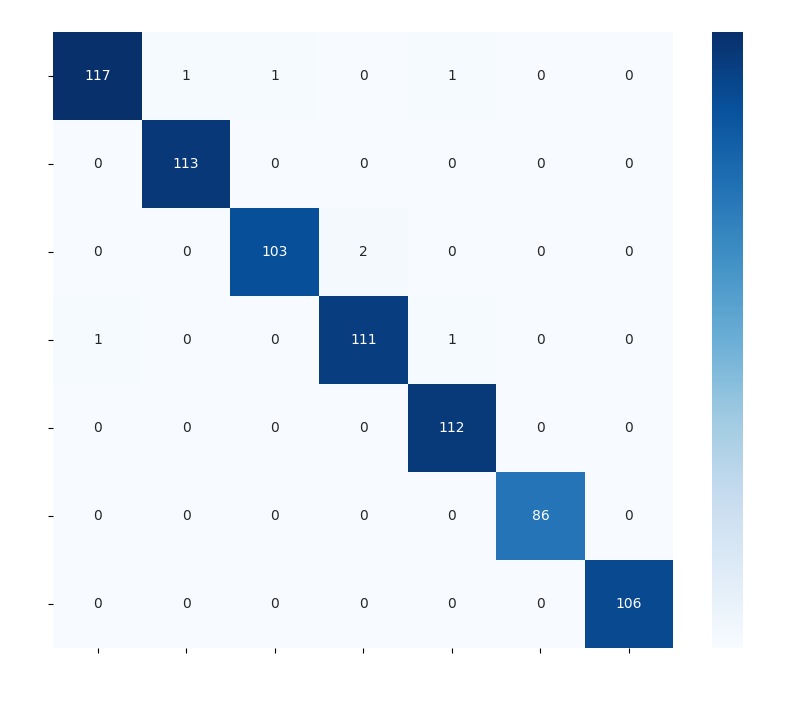

In [168]:
plot_confusion_matrix_heatmap(y_train, pred_train, class_names, "final model - Training Set")


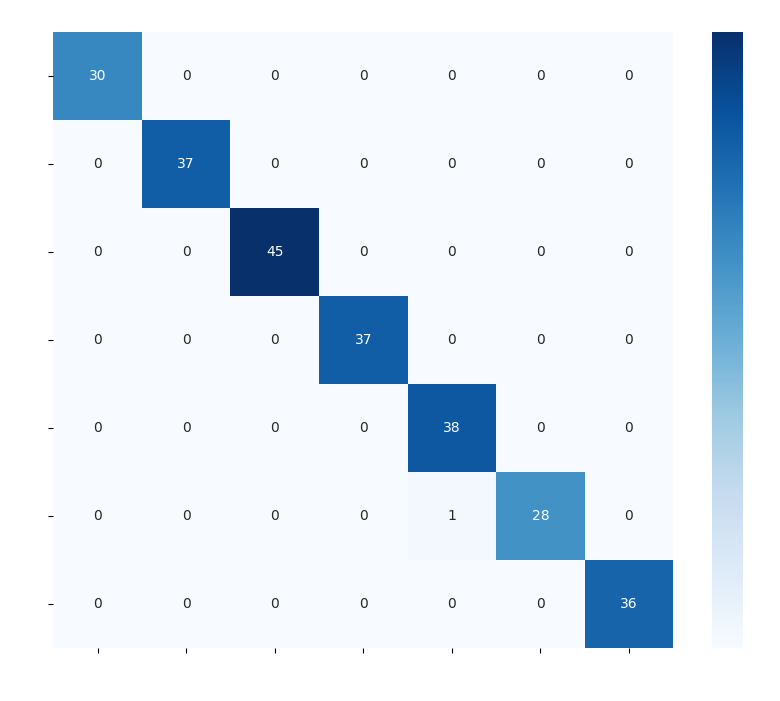

In [164]:
plot_confusion_matrix_heatmap(np.array(y_test), np.array(pred_test), class_names, "final model - Test Set")

In [73]:
def calculate_accuracy(y_true, y_pred):
    # Ensure y_true and y_pred are NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compare predicted labels with true labels and count correct predictions
    correct_predictions = np.sum(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

    # Calculate accuracy
    total_predictions = len(y_true)
    accuracy = correct_predictions / total_predictions

    return accuracy

In [76]:
calculate_accuracy(y_train, pred_train), calculate_accuracy(y_test, pred_test)

(0.990728476821192, 0.996031746031746)

In [180]:
# first model
best_model=pickle.load(open("DenseNet_s150_e91.sav", "rb"))
#make predictions
pred_train=best_model.predict(X_train).round(2)
pred_train,y_train
# make predictions using test dataset
pred_test=best_model.predict(X_test).round(2)
pred_test,y_test

8/8 [==============================] - 25s 3s/step


(array([[0.01, 0.01, 0.01, ..., 0.95, 0.01, 0.01],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.98],
        [0.  , 0.  , 0.  , ..., 0.  , 0.97, 0.  ],
        ...,
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.98],
        [0.01, 0.01, 0.01, ..., 0.93, 0.01, 0.01],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.98]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]))

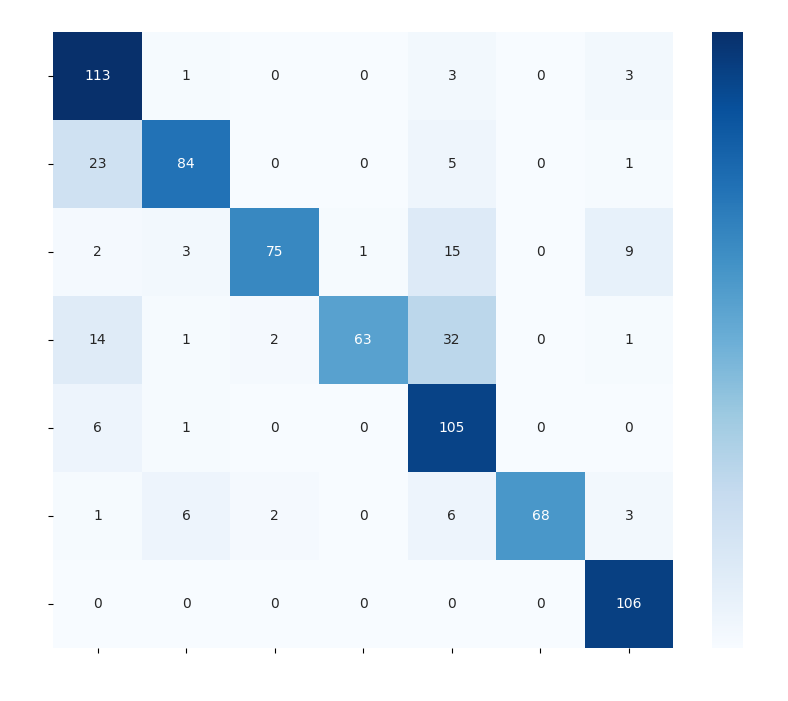

In [181]:
plot_confusion_matrix_heatmap(y_train, pred_train, class_names, "first model - Training Set")


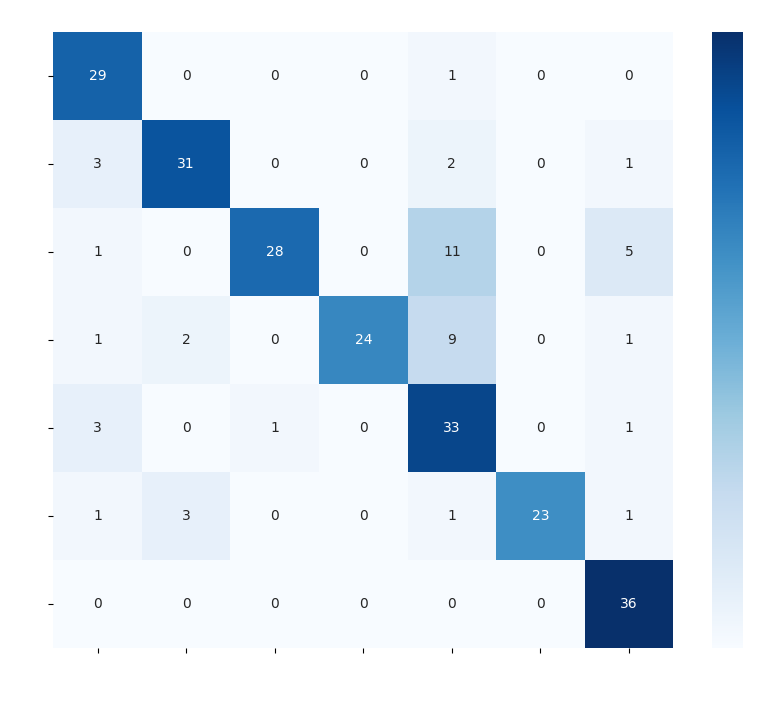

In [182]:
plot_confusion_matrix_heatmap(np.array(y_test), np.array(pred_test), class_names, "first model - Test Set")

In [183]:
calculate_accuracy(y_train, pred_train), calculate_accuracy(y_test, pred_test)

(0.8132450331125828, 0.8095238095238095)